In [2]:
!pip install gym_super_mario_bros==7.3.0 nes_py
!pip install torch==1.10.1+cu113 torchvision==0.11.2+cu113 torchaudio===0.10.1+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html
!pip install stable-baselines3[extra]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 198 kB 29.1 MB/s 
     |████████████████████████████████| 77 kB 7.1 MB/s 
     |████████████████████████████████| 1.1 MB 52.1 MB/s 
  Created wheel for nes-py: filename=nes_py-8.2.1-cp37-cp37m-linux_x86_64.whl size=435592 sha256=0e0bc3feefe7a1b14ca7fe57673e6c6f0f3be58c0a14d1f536a7d77ddec013e5
  Stored in directory: /root/.cache/pip/wheels/17/96/0e/22a8c7dbdf412d8e988286f223b223baf0f4ad90c9e699c56d
Successfully built nes-py
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.3 MB/s eta 0:12:47tcmalloc: large alloc 1147494400 bytes == 0x39068000 @  0x7ff274f11615 0x58ead6 0x4f355e 0x4d222f 0x51041f 0x5b4ee6 0x58ff2e 0x510325 0x5b4ee6 0x58ff2e 0x50d482 0x4d00fb 0x50cb8d 0x4d00fb 0x5

In [3]:
#Lander Borbe

#Importing Libraries and game
import io
import base64
import os 
import gym_super_mario_bros

from matplotlib import pyplot as plt
from IPython.display import HTML
from nes_py.wrappers import JoypadSpace
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT
from stable_baselines3 import PPO
from stable_baselines3.common.callbacks import BaseCallback
from gym.wrappers import GrayScaleObservation
from stable_baselines3.common.vec_env import VecFrameStack, DummyVecEnv

In [4]:
game_envi = gym_super_mario_bros.make('SuperMarioBros-v3')
game_envi = JoypadSpace(game_envi, SIMPLE_MOVEMENT)

In [5]:
game_envi = GrayScaleObservation(game_envi, keep_dim=True)
game_envi = DummyVecEnv([lambda: game_envi])

In [6]:
game_envi = VecFrameStack(game_envi, 4, channels_order='last')

In [7]:
state = game_envi.reset()

In [8]:
state, reward, done, info = game_envi.step([5])

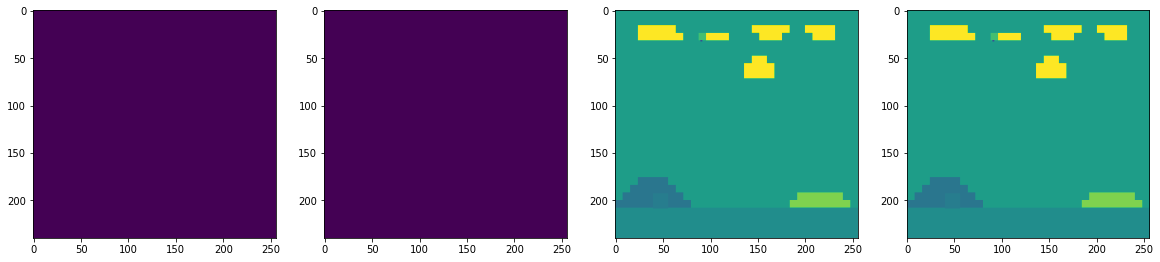

In [9]:
#Map display

plt.figure(figsize=(20,16))
for idx in range(state.shape[3]):
    plt.subplot(1,4,idx+1)
    plt.imshow(state[0][:,:,idx])
plt.show()

In [10]:
class TrainAndLoggingCallback(BaseCallback):
    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)
        return True

In [11]:
CHECKPOINT_DIR = 'checkpoint'

In [12]:
LOG_DIR = 'logs'

In [13]:
CB = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [14]:
#AI Model

model = PPO('CnnPolicy', game_envi, verbose=1, tensorboard_log=LOG_DIR, learning_rate=0.000001, 
            n_steps=512) 

Using cuda device
Wrapping the env in a VecTransposeImage.


In [15]:
#Model training

model.learn(total_timesteps=50000, callback=CB)

Logging to logs/PPO_1


/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


----------------------------
| time/              |     |
|    fps             | 31  |
|    iterations      | 1   |
|    time_elapsed    | 16  |
|    total_timesteps | 512 |
----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 41            |
|    iterations           | 2             |
|    time_elapsed         | 24            |
|    total_timesteps      | 1024          |
| train/                  |               |
|    approx_kl            | 2.4242094e-05 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.95         |
|    explained_variance   | -0.00392      |
|    learning_rate        | 1e-06         |
|    loss                 | 142           |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000253     |
|    value_loss           | 380           |
-------------------------------------------
-----

In [16]:
#Saving Model
model.save('borbe_model')

In [20]:
#Load Model
model = PPO.load('/content/borbe_model.zip')

In [21]:
state = game_envi.reset()

In [23]:
#recording
from gym import wrappers
game_envi = gym_super_mario_bros.make('SuperMarioBros2-v0')
game_envi = wrappers.Monitor(game_envi, "./gym-results", force=True)
game_envi.reset()
for _ in range(4000):
    action = game_envi.action_space.sample()
    state, reward, done, info = game_envi.step(action)
    if done: break
game_envi.close()

/usr/local/lib/python3.7/dist-packages/gym_super_mario_bros/smb_env.py:148: RuntimeWarning: overflow encountered in ubyte_scalars
  return (self.ram[0x86] - self.ram[0x071c]) % 256


In [24]:
#video

video = io.open('./gym-results/openaigym.video.%s.video000000.mp4' % game_envi.file_infix, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''
    <video width="360" height="auto" alt="test" controls><source src="data:video/mp4;base64,{0}" type="video/mp4" /></video>'''
.format(encoded.decode('ascii')))